In [1]:
# IMPORTS
import PGC
from scipy import signal
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib

/home/jy46/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jy46/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jy46/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jy46/anaconda3/envs/tf/lib/python3.7/site-packages/tensorf

In [2]:
# FONT SIZE FOR FIGURES
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# PARAMETERS

# Time parameters
time_step = 1/32
time_max = (1-time_step)

# Number of trials
num_trials = int(1e4)

# Number of bootstrap iterations
num_boot_iter = 100

# Frequency for time processes
f0 = 2;

# Scales for Rayleigh RVs for X, W, and Z amplitude
X_scale = 1
W_scale = 1
Z_scale = 1

In [4]:
# GENERATE TIME (include time_max in time by adding one additional time_step)
time = np.arange(0,time_max+time_step,time_step)
time_array = npm.repmat(time[:, None].T,num_trials,1)

In [5]:
# GENERATE THREE PROCESSES
# First generate random amplitudes
X_amp = npm.repmat(np.random.rayleigh(X_scale,(num_trials,1)),1,len(time))
W_amp = npm.repmat(np.random.rayleigh(W_scale,(num_trials,1)),1,len(time))
Z_amp = npm.repmat(np.random.rayleigh(Z_scale,(num_trials,1)),1,len(time))

# Next generate random phases
X_phase = npm.repmat(2*math.pi*np.random.uniform(size=(num_trials,1)),1,len(time))
W_phase = npm.repmat(2*math.pi*np.random.uniform(size=(num_trials,1)),1,len(time))
Z_phase = npm.repmat(2*math.pi*np.random.uniform(size=(num_trials,1)),1,len(time))

# Now generate random processes
X = X_amp*np.cos((2*math.pi*f0*time_array)+X_phase)
#W = np.sqrt(0.5)*X+np.sqrt(0.5)*W_amp*np.cos((2*math.pi*f0*time_array)+W_phase)
#Z = np.sqrt(0.5)*W+np.sqrt(0.5)*Z_amp*np.cos((2*math.pi*f0*time_array)+Z_phase)
W = X+W_amp*np.cos((2*math.pi*f0*time_array)+W_phase)
Z = W+Z_amp*np.cos((2*math.pi*f0*time_array)+Z_phase)

X = X + (0.001)*np.random.normal(size=(X_phase.shape))
W = W + (0.001)*np.random.normal(size=(X_phase.shape))
Z = Z + (0.001)*np.random.normal(size=(X_phase.shape))

In [6]:
# ESTIMATE COH, PCOH, MIF, & PGC
data = np.stack((X,W,Z),axis=0)
f = np.fft.fftfreq(len(time),time_step)

f_of_interest = np.where(f0==f)[0][0]

P, C = PGC.pcoh(data,time_step,time_max)
C[np.eye(C.shape[0]).astype(bool)]=0
P[np.eye(P.shape[0]).astype(bool)]=0

MIF = PGC.pgc(data,num_boot_iter,f_of_interest)
PGC = PGC.pgc(data,num_boot_iter,f_of_interest,f_of_interest,f_of_interest)

Tester = Classifier, metric = donsker_varadhan



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






Tester = Classifier, metric = donsker_varadhan


Tester = Classifier, metric = donsker_varadhan


Tester = Classifier, metric = donsker_varadhan


Tester = Classifier, metric = donsker_varadhan


Tester = Classifier, metric = donsker_varadhan


In [7]:
# LOG TRANSFORMATION OF COHERENCE & PARTIAL COHERENCE
C_log = -np.log(1-C)
P_log = -np.log(1-P)

In [8]:
spectral_matrix = np.zeros((3,3))
spectral_matrix[0,1] = np.log(1+((X_scale**2)/(W_scale**2)))
spectral_matrix[1,0] = spectral_matrix[0,1]
spectral_matrix[1,2] = np.log(1+(((X_scale**2)+(W_scale**2))/(Z_scale**2)))
spectral_matrix[2,1] = spectral_matrix[1,2]
spectral_matrix[0,2] = np.log(1+((X_scale**2)/((Z_scale**2)+(W_scale**2))))
spectral_matrix[2,0] = spectral_matrix[0,2]

In [9]:
# TRUE MIF VALUES
MIF_true = np.zeros((data.shape[0],data.shape[0]))
MIF_true[0,1] = np.log(1+((X_scale**2)/(W_scale**2)))
MIF_true[1,0] = MIF_true[0,1]
MIF_true[1,2] = np.log(1+(((X_scale**2)+(W_scale**2))/(Z_scale**2)))
MIF_true[2,1] = MIF_true[1,2]
MIF_true[0,2] = np.log(1+((X_scale**2)/((Z_scale**2)+(W_scale**2))))
MIF_true[2,0] = MIF_true[0,2]

In [10]:
# TRUE PGC
from scipy.linalg import fractional_matrix_power
S_mat = 0.5*np.asarray([[1,1,1],[1,2,2],[1,2,3]])
S_mat_inv = np.linalg.inv(S_mat)
denom = npm.repmat(np.diag(S_mat_inv),3,1)*(npm.repmat(np.diag(S_mat_inv),3,1).T)
P_mat = -S_mat_inv/np.sqrt(denom)
PGC_true = -np.log(1-(P_mat)**2)
PGC_true[0,0]=0
PGC_true[1,1]=0
PGC_true[2,2]=0
PGC_true

/home/jy46/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


array([[ 0.        ,  0.28768207, -0.        ],
       [ 0.28768207,  0.        ,  0.69314718],
       [-0.        ,  0.69314718,  0.        ]])

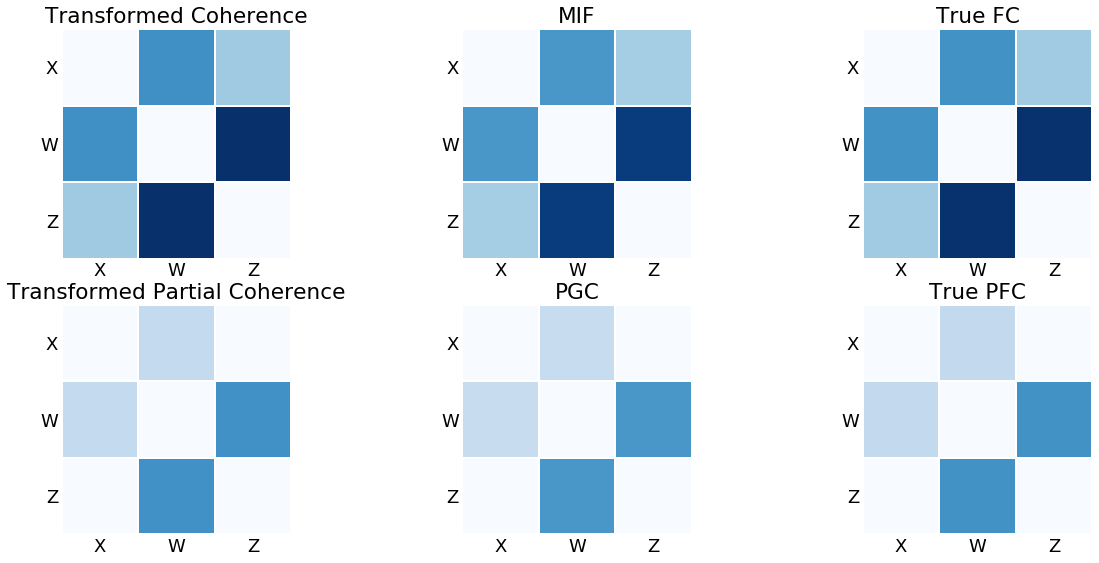

In [11]:
# PLOT RESULTS

# FONT SIZE FOR FIGURES
matplotlib.rcParams.update({'font.size': 18})

f_plt, ax = plt.subplots(figsize=(17, 8));
f_plt.tight_layout()

lw=1
max_val = np.max(np.stack((MIF_true,PGC_true,MIF,PGC,np.squeeze(C_log[:,:,f==f0]),
                           np.squeeze(P_log[:,:,f==f0]))))

ax = plt.subplot(231)
sns.heatmap(np.squeeze(C_log[:,:,f==f0]),square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('Transformed Coherence')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim((3,0));

ax = plt.subplot(234)
sns.heatmap(np.squeeze(P_log[:,:,f==f0]),square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('Transformed Partial Coherence')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim((3,0));

ax = plt.subplot(232)
sns.heatmap(MIF,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('MIF')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim((3,0));

ax = plt.subplot(235)
sns.heatmap(PGC,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('PGC')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim((3,0));

ax = plt.subplot(233)
sns.heatmap(MIF_true,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('True FC')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim((3,0));

ax = plt.subplot(236)
sns.heatmap(PGC_true,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('True PFC')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0);
plt.ylim((3,0));

plt.savefig('figure3.pdf');

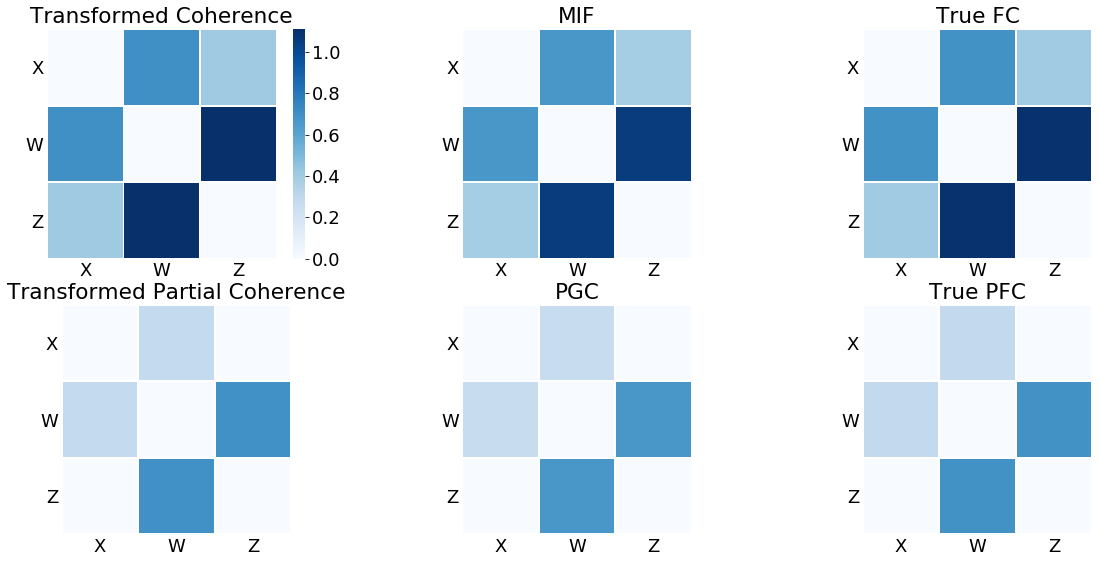

In [12]:
# PLOT RESULTS

# FONT SIZE FOR FIGURES
matplotlib.rcParams.update({'font.size': 18})

f_plt, ax = plt.subplots(figsize=(17, 8));
f_plt.tight_layout()

lw=1
max_val = np.max(np.stack((MIF_true,PGC_true,MIF,PGC,np.squeeze(C_log[:,:,f==f0]),
                           np.squeeze(P_log[:,:,f==f0]))))

ax = plt.subplot(231)
sns.heatmap(np.squeeze(C_log[:,:,f==f0]),square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=True)
plt.title('Transformed Coherence')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim((3,0));

ax = plt.subplot(234)
sns.heatmap(np.squeeze(P_log[:,:,f==f0]),square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('Transformed Partial Coherence')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim((3,0));

ax = plt.subplot(232)
sns.heatmap(MIF,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('MIF')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim((3,0));

ax = plt.subplot(235)
sns.heatmap(PGC,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('PGC')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim((3,0));

ax = plt.subplot(233)
sns.heatmap(MIF_true,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('True FC')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim((3,0));

ax = plt.subplot(236)
sns.heatmap(PGC_true,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('True PFC')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0);
plt.ylim((3,0));

plt.savefig('figure3_colorbar.pdf');

In [13]:
from scipy.io import savemat
data_to_save = {"C_log": C_log, "P_log": P_log, 
        "MIF": MIF, "PGC":PGC, "MIF_true":MIF_true, "PGC_true":PGC_true }
savemat("data.mat", data_to_save)